In [1]:
import matplotlib.pyplot as plt
from math import pi
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn

from sklearn import preprocessing, model_selection
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn import metrics
from matplotlib import rcParams
from matplotlib import pyplot
import plotly.express as px
rcParams['axes.titlepad'] = 10

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score


recall: 0.8281


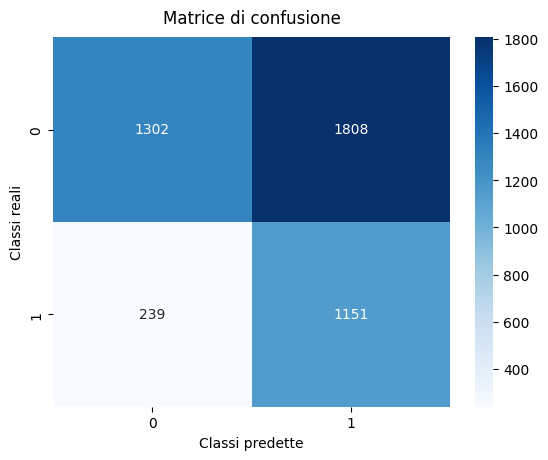

In [2]:
df =pd.read_csv("aids.csv")
df.head()

X = df.drop('infected', axis=1)  
y = df['infected'].astype(int)  # Assicurati che y sia di tipo int (binario)
X_encoded = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=45)

best_params = {
    'subsample': 0.6, 
    'scale_pos_weight': 4, 
    'reg_lambda': 5, 
    'reg_alpha': 5, 
    'min_child_weight': 1, 
    'max_depth': 3, 
    'gamma': 0.3, 
    'colsample_bytree': 0.8}

#fit the model on train set
xgb_clf = XGBClassifier(**best_params)
xgb_clf.fit(X_train, y_train)

# Predictions on  test set
y_pred = xgb_clf.predict(X_test)

#calculate the recall
recall = recall_score(y_test, y_pred)
print('recall: {0:0.4f}'.format(recall))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Classi predette')
plt.ylabel('Classi reali')
plt.title('Matrice di confusione')
plt.show()

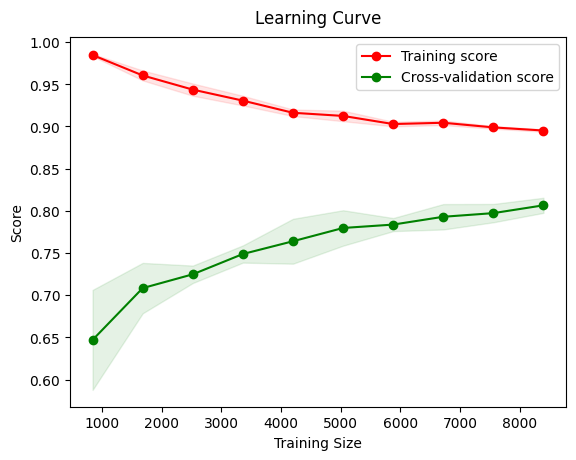

In [3]:
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer, recall_score

train_sizes, train_scores, test_scores = learning_curve(xgb_clf, X_train, y_train, cv=5, scoring='recall', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='r', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='g', alpha=0.1)
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Cross-validation score')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend(loc="best")
plt.show()

##### Interpretable Machine Learning methods

###### Feature importance

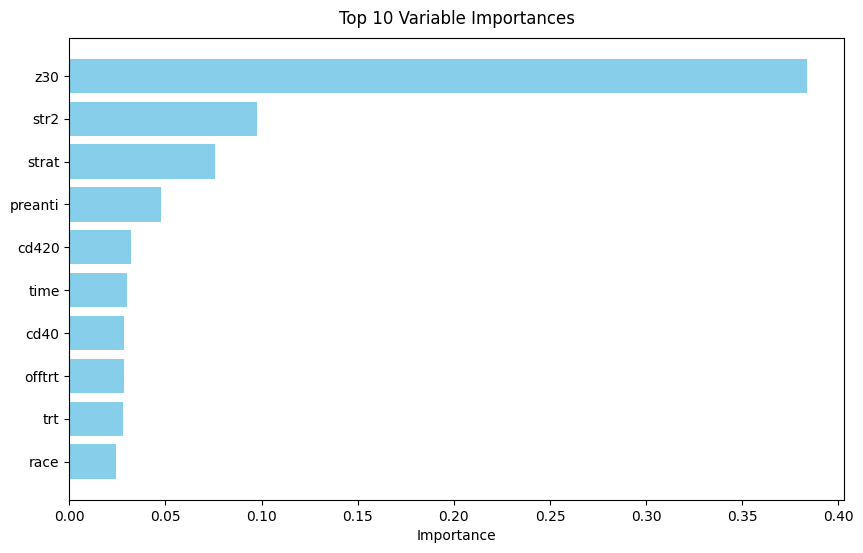

In [4]:
importance = xgb_clf.feature_importances_
features = X_test.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(10), importance_df['Importance'].head(10), color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Variable Importances')
plt.gca().invert_yaxis() 
plt.show()

###### Permutation feature importance

###### Partial dependence plot

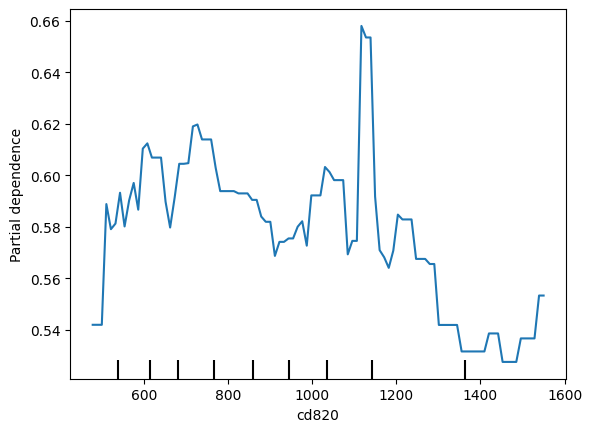

In [5]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(xgb_clf, 
                                        X_test, 
                                        ['cd820'])

###### Accumulated local efffects

PyALE._ALE_generic:INFO: Continuous feature detected.


['time', 'trt', 'age', 'wtkg', 'hemo', 'homo', 'drugs', 'karnof', 'oprior', 'z30', 'preanti', 'race', 'gender', 'str2', 'strat', 'symptom', 'treat', 'offtrt', 'cd40', 'cd420', 'cd80', 'cd820']


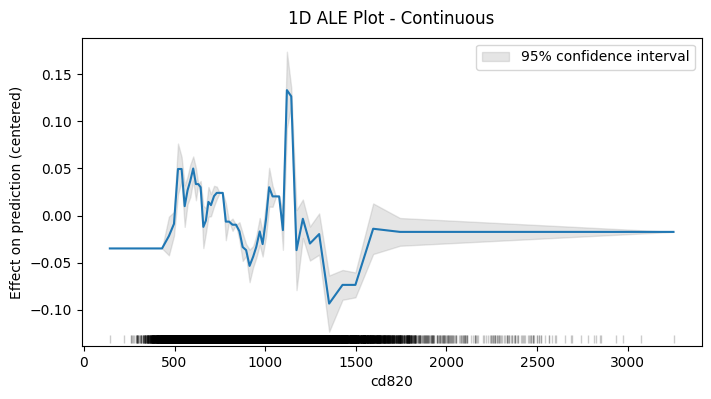

In [6]:
from PyALE import ale

features = X_encoded.columns.tolist()
print(features)
ale_eff = ale(X = X_encoded[features], model = xgb_clf, feature = ['cd820'], grid_size = 50)

###### Individual conditional expectations plot

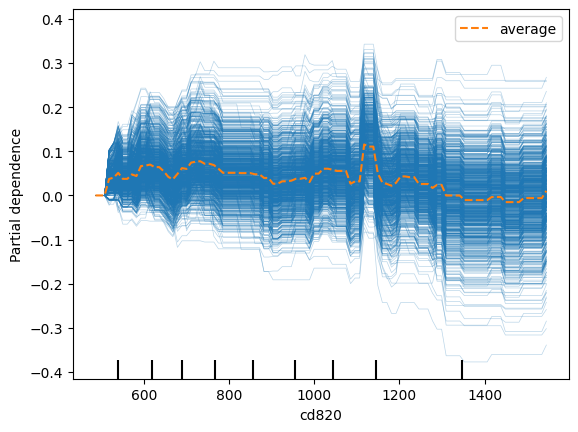

In [7]:
from sklearn.inspection import PartialDependenceDisplay

features_info = {
    "features": ["cd820"],
    "kind": "both",
    "centered": True,
}
PartialDependenceDisplay.from_estimator(
    xgb_clf,
    X_train,
    **features_info
)

###### Shapley values

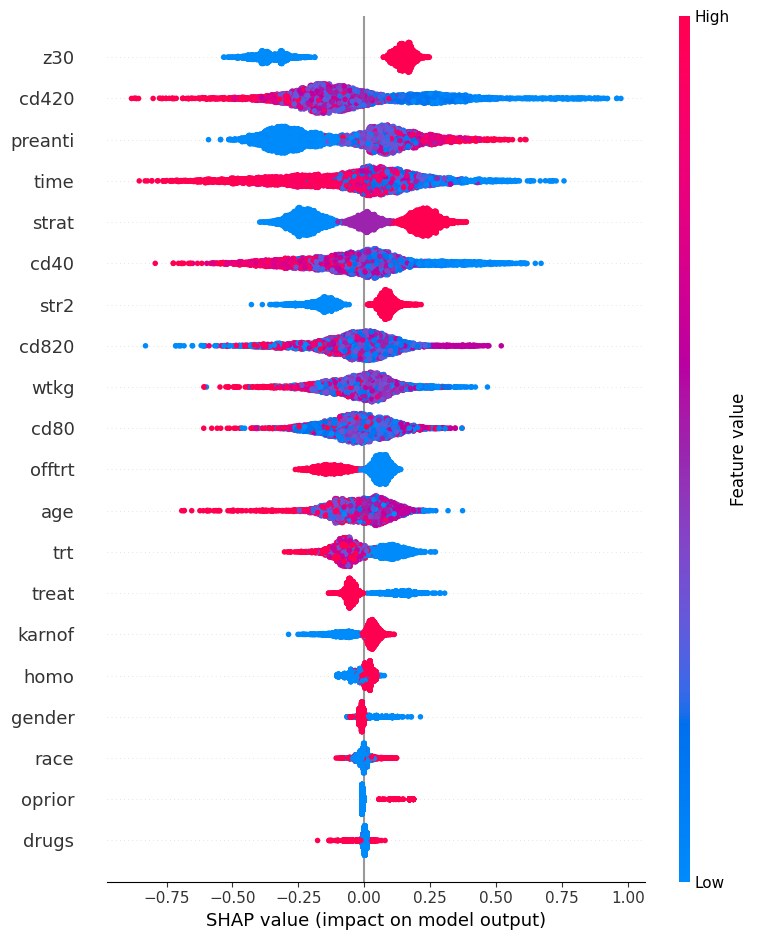

In [8]:
import shap
#Calcolo dei valori SHAP
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer(X_test)
expected_value = explainer.expected_value #valore atteso delle predizioni del modello

# Genera il plot SHAP summary
shap.summary_plot(shap_values, X_test, title="SHAP summary plot")


In [9]:
predictions_proba = xgb_clf.predict_proba(X_test)
positive_class_proba = predictions_proba[:, 1]
# Find TP
true_positive_indices = np.where((positive_class_proba > 0.5) & (y_test == 1))[0]
print("True positives instances:")
print(true_positive_indices)
print("Number of True positives: ",len(true_positive_indices))
# Find FN
false_negatives_indices = np.where((positive_class_proba < 0.5) & (y_test == 1))[0]
print("False negatives instances:")
print(false_negatives_indices)
print("Number of False negatives: ",len(false_negatives_indices))

True positives instances:
[   3    7    9 ... 4491 4494 4499]
Number of True positives:  1151
False negatives instances:
[   8   26   60   84   93  101  102  134  157  164  173  185  191  215
  222  241  246  248  258  262  285  288  330  348  358  364  442  450
  473  520  524  572  587  588  596  609  674  683  695  714  727  742
  752  781  794  814  820  843  844  849  881  884  953  970  981  991
 1000 1011 1060 1100 1105 1120 1144 1152 1158 1204 1240 1241 1250 1251
 1271 1276 1294 1297 1323 1336 1353 1358 1360 1375 1413 1420 1432 1457
 1469 1477 1576 1591 1648 1661 1669 1677 1685 1687 1708 1717 1731 1758
 1778 1867 1874 1896 1911 2024 2028 2029 2031 2046 2060 2083 2114 2134
 2139 2162 2175 2179 2182 2206 2215 2239 2245 2322 2334 2378 2393 2409
 2413 2449 2470 2489 2498 2571 2578 2581 2621 2630 2632 2640 2642 2663
 2675 2694 2704 2719 2723 2724 2740 2742 2743 2802 2871 2891 2915 2918
 2919 2923 2926 2958 2975 2977 2986 2988 3003 3038 3040 3076 3091 3103
 3123 3138 3173 3174 3191 3

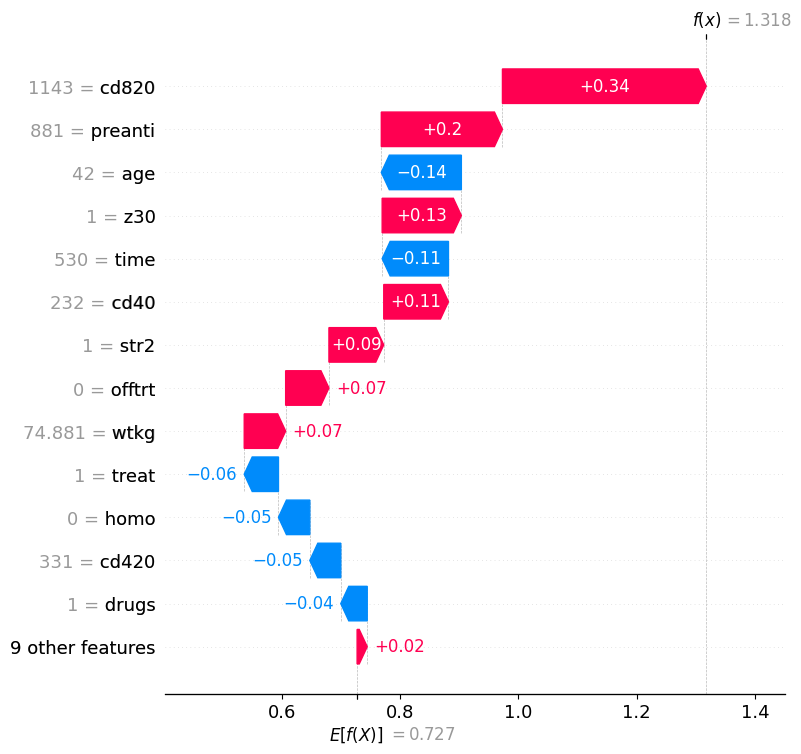

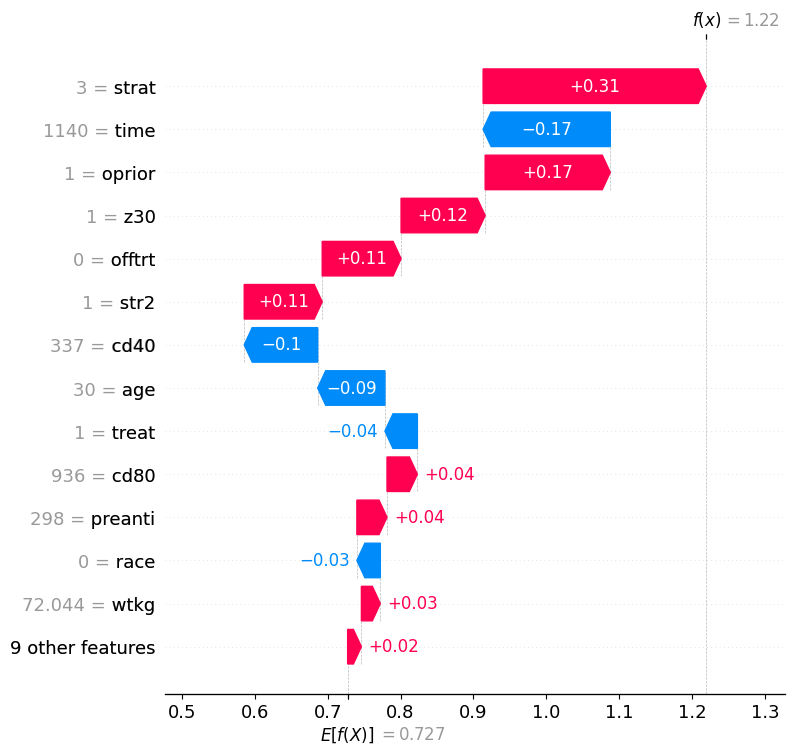

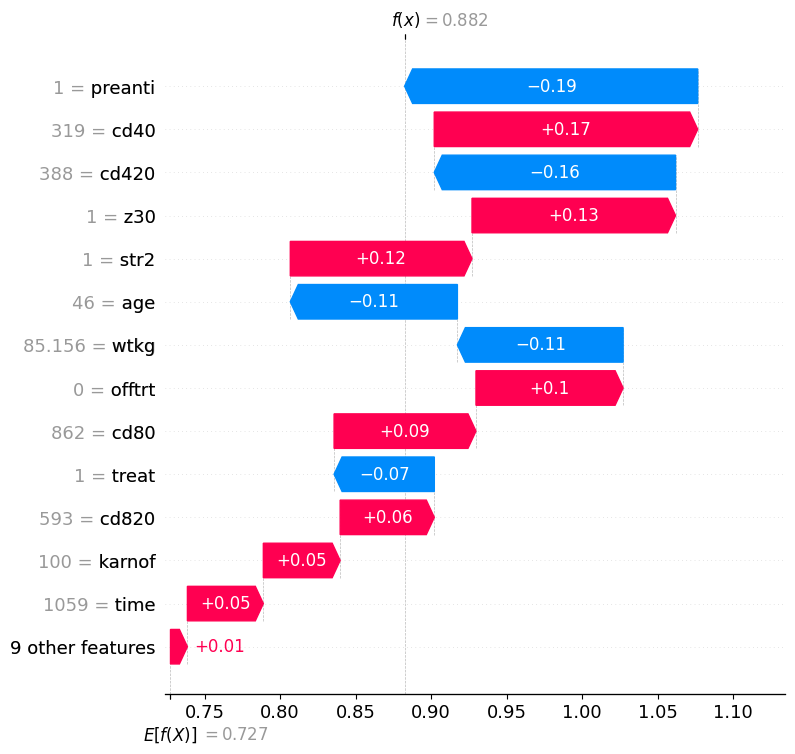

In [10]:
#TP
shap.plots.waterfall(shap_values[3], max_display=14)
shap.plots.waterfall(shap_values[7], max_display=14)
shap.plots.waterfall(shap_values[9], max_display=14)

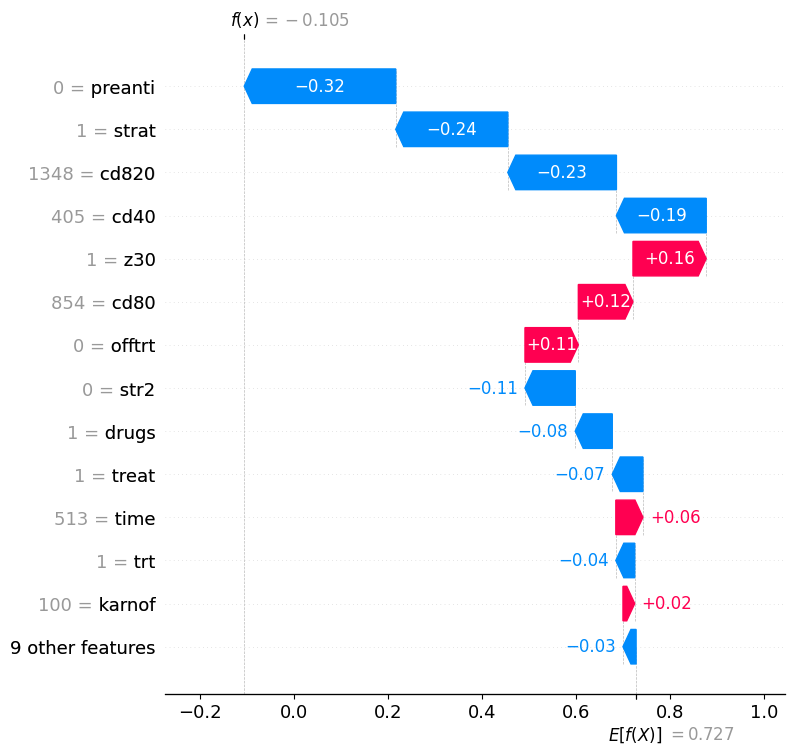

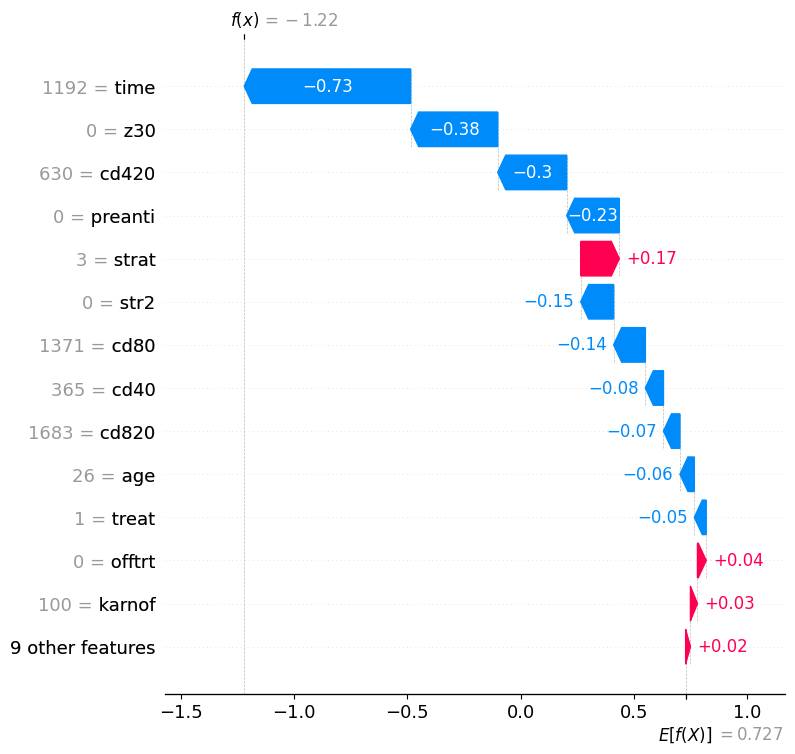

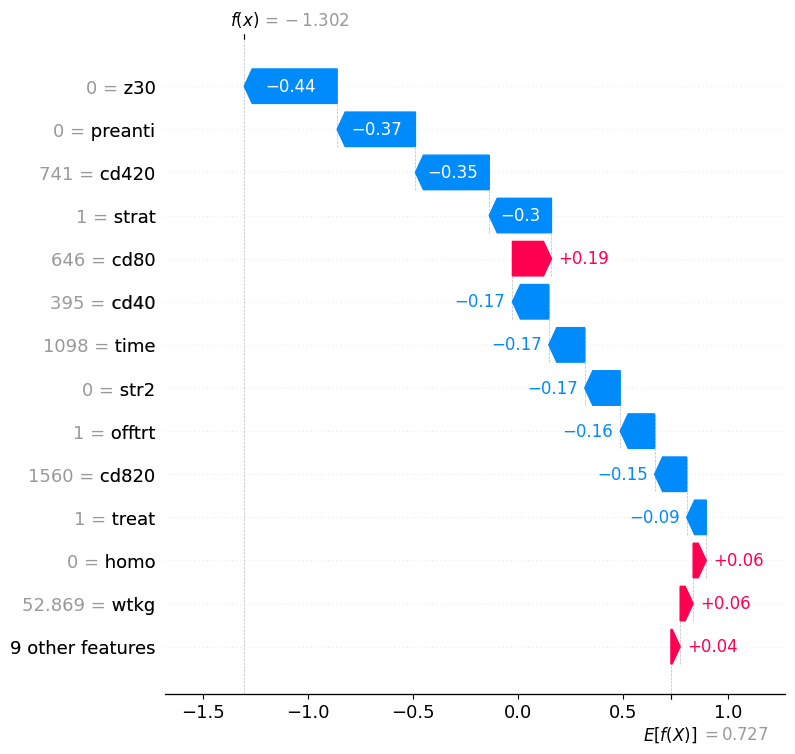

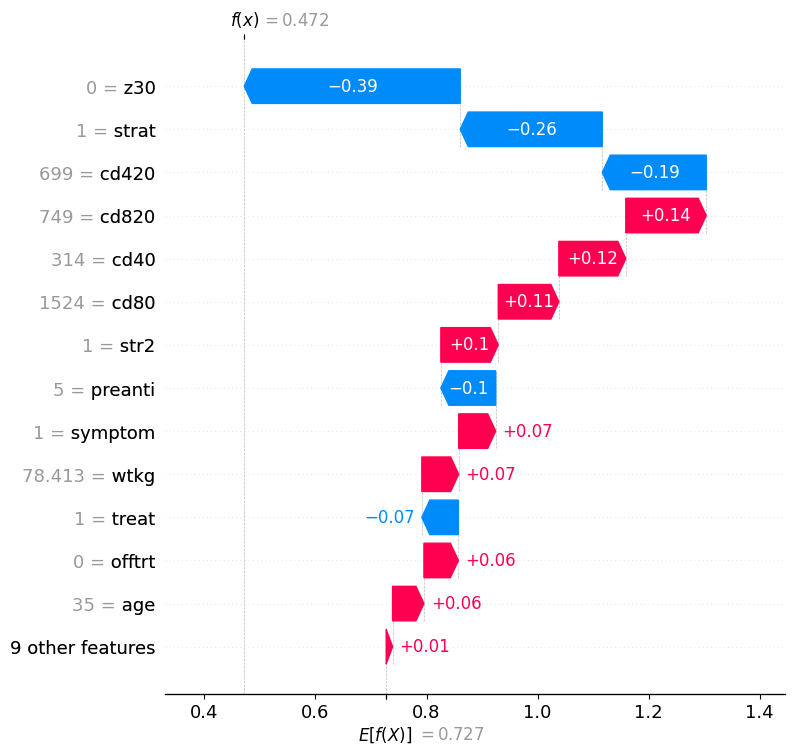

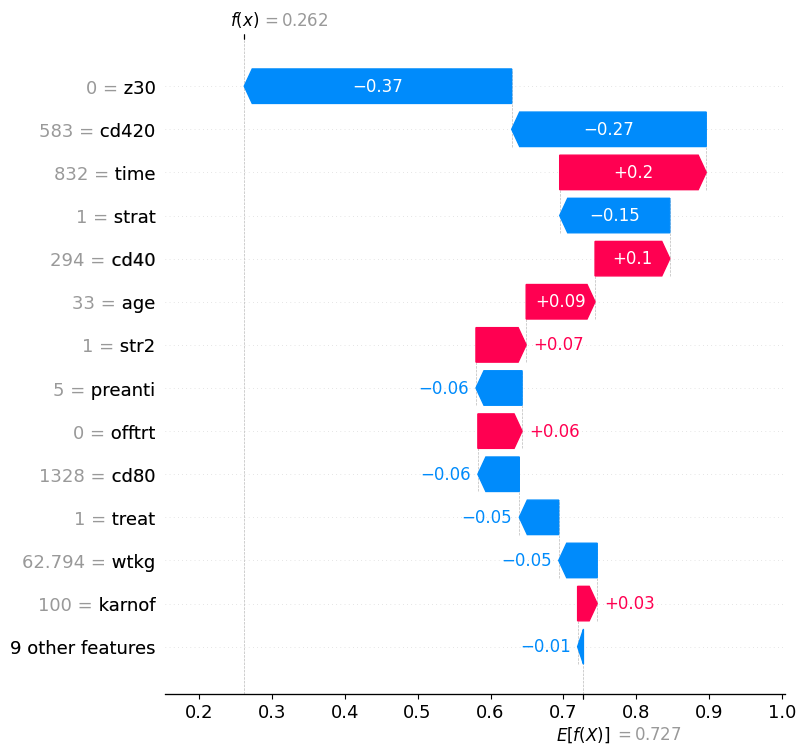

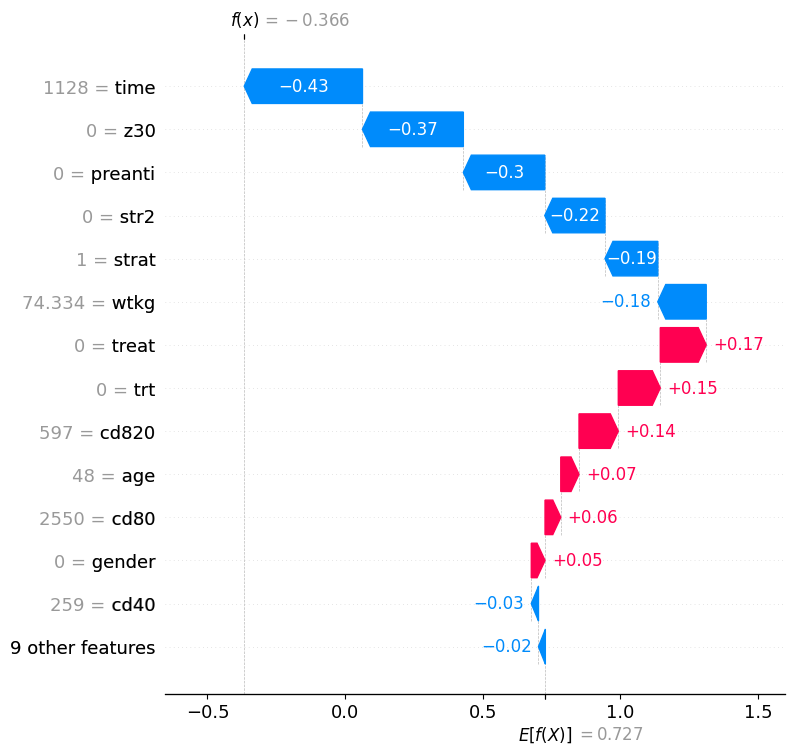

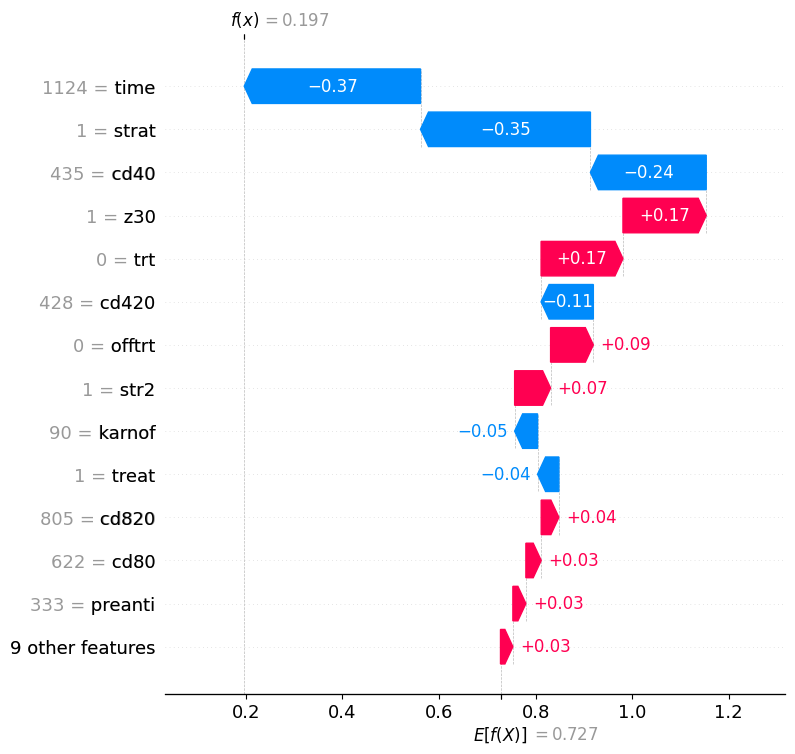

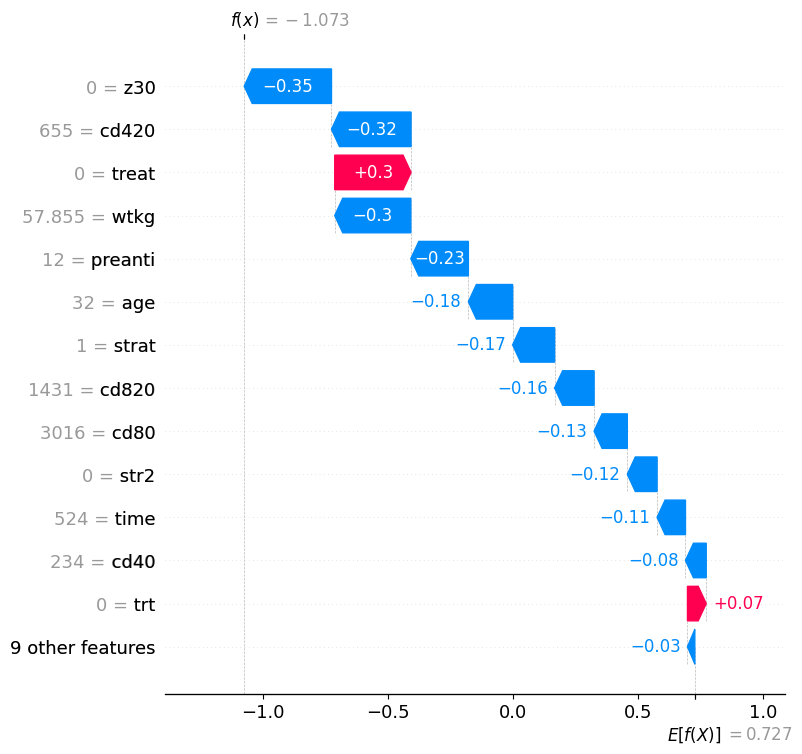

In [11]:
#FN
shap.plots.waterfall(shap_values[8], max_display=14)
shap.plots.waterfall(shap_values[26], max_display=14)
shap.plots.waterfall(shap_values[60], max_display=14)
shap.plots.waterfall(shap_values[63], max_display=14)
shap.plots.waterfall(shap_values[72], max_display=14)
shap.plots.waterfall(shap_values[84], max_display=14)
shap.plots.waterfall(shap_values[97], max_display=14)
shap.plots.waterfall(shap_values[101], max_display=14)

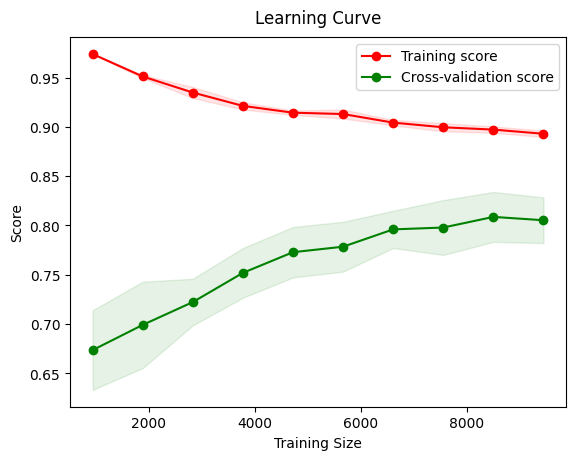

In [12]:
train_sizes, train_scores, test_scores = learning_curve(xgb_clf, X_train, y_train, cv=10, scoring='recall', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='r', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='g', alpha=0.1)
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Cross-validation score')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend(loc="best")
plt.show()

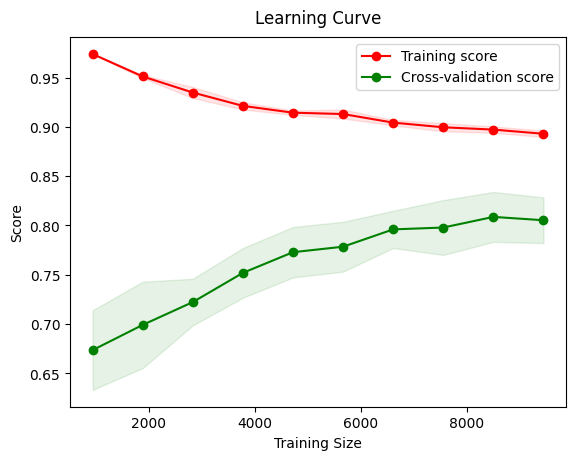

In [13]:
train_sizes, train_scores, test_scores = learning_curve(xgb_clf, X_train, y_train, cv=10, scoring='recall', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='r', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='g', alpha=0.1)
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Cross-validation score')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend(loc="best")
plt.show()

###### lime

In [14]:
import lime
from lime import lime_tabular

# Assuming xgb_clf is a trained XGBoost classifier
# Ensure xgb_clf.predict_proba is available
try:
    getattr(xgb_clf, 'predict_proba')
except AttributeError:
    raise AttributeError("The XGBoost model must have 'predict_proba' method for LIME explanations.")

# Create LIME explainer
explainer_lime = lime.lime_tabular.LimeTabularExplainer(X_test.values,
                                      feature_names=X_test.columns.tolist(),
                                      class_names=['infected'], 
                                      verbose=True, mode='classification')

In [15]:
# Explain instance using predict_proba
exp = explainer_lime.explain_instance(X_test.values[30], xgb_clf.predict_proba, num_features=6)

# Show the explanations in notebook
exp.show_in_notebook(show_table=True)

Intercept 0.44318325331817277
Prediction_local [0.75365353]
Right: 0.7656158


###### anchors

In [16]:
from anchor import anchor_tabular

feature_names = X_test.columns
class_names = [str(cls) for cls in y.unique()]

explainer = anchor_tabular.AnchorTabularExplainer(
    class_names=class_names,
    feature_names=feature_names,
    train_data=X_test.values
)

In [17]:
np.random.seed(2)
sample_to_explain = X_test.iloc[4].values
exp = explainer.explain_instance(sample_to_explain, xgb_clf.predict)

print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())

Precision: 0.98
Coverage: 0.01


In [18]:
exp.show_in_notebook()